In [2]:
import sys
import os
import random
import progressbar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input

from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from textwrap import wrap

# Path Hanlding

In [3]:
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount=True)
  dataset_path = "drive/MyDrive/LTU/ADL/Lab-3/Flickr8k/"
else:
  dataset_path = "./Flickr8k/"

print(f"Dataset path : {dataset_path}")
image_path = dataset_path+"Images/"
print(f"Images path  : {image_path}")

image_dir = os.listdir(image_path)

Dataset path : ./Flickr8k/
Images path  : ./Flickr8k/Images/


In [4]:
captions = pd.read_csv(dataset_path+"captions.txt")
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# Functions

In [5]:
def showImage(image_path, captions, r):
  # display a single image and its caption
  m = len(os.listdir(image_path))
  r = min(r,m)
  image_path = f"{image_path}{captions.image[r]}"
  image = plt.imread(image_path)

  plt.figure(figsize = (5 , 5))
  plt.imshow(image)
  plt.title(captions.caption[r])
  plt.axis("off")

def showImages(image_path, captions, grid, showrandom=True, captionCol='caption'):
  # display a grid of random images
  m = len(os.listdir(image_path))
  plt.figure(figsize = (4*grid[1] , 4*grid[0]))
  ii = grid[0]*grid[1]
  n=0
  for i in range(ii):
    n+=1
    plt.subplot(grid[0] , grid[1], n)
    
    if showrandom:
      r = random.randint(0, m)
    else:
      r = n - 1
    
    plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
    image = plt.imread(f"{image_path}{captions.image[r]}")
    plt.imshow(image)
    #plt.title("\n".join(wrap(captions.caption[r], 25)))
    plt.title("\n".join(wrap(captions[captionCol][r], 25)))
    plt.axis("off")




def text_preprocessing(data):
  pp = data.copy()
  pp['caption'] = pp['caption'].apply(lambda x: x.lower())
  pp['caption'] = pp['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
  pp['caption'] = pp['caption'].apply(lambda x: x.replace("\s+"," "))
  pp['caption'] = pp['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
  pp['caption'] = "startseq "+pp['caption']+" endseq"
  pp['word_count'] = pp['caption'].apply(lambda x: len(x.split()))
  return pp



# Classes

In [6]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

# Visualization

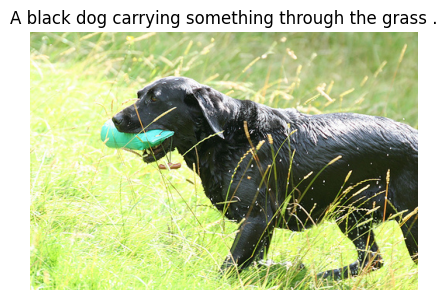

In [7]:
showImage(image_path, captions, 111)

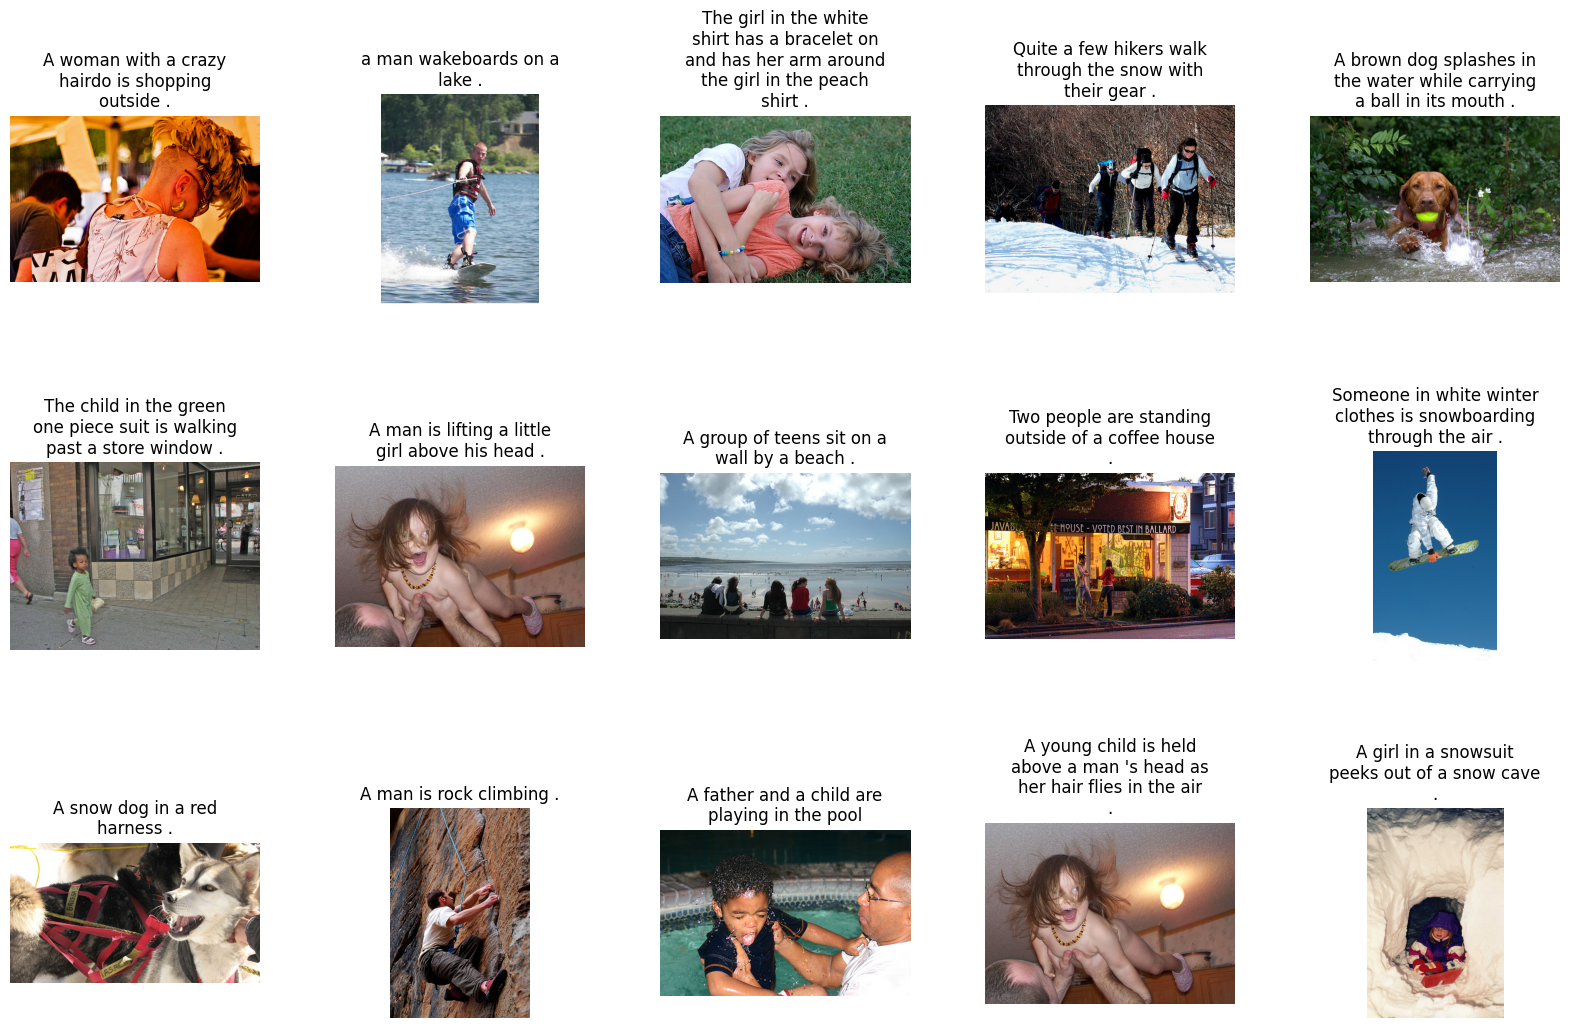

In [8]:
showImages(image_path, captions, [3,5])

# Text Pre-Processing

In [9]:
captions_pp = text_preprocessing(captions)

In [10]:
captions_pp

,image,caption,word_count
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up se...,16
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq,7
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden play...,8
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to he...,10
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into ...,11
...,...,...,...
40450,997722733_0cb5439472.jpg,startseq man in pink shirt climbs rock face en...,9
40451,997722733_0cb5439472.jpg,startseq man is rock climbing high in the air ...,10
40452,997722733_0cb5439472.jpg,startseq person in red shirt climbing up rock ...,14
40453,997722733_0cb5439472.jpg,startseq rock climber in red shirt endseq,7


In [11]:
caption_list = captions_pp['caption'].tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(caption_list)
vocab_size = len(tokenizer.word_index) + 1
max_length = captions_pp['word_count'].max()

print(f"Vocabulary size = {vocab_size}")
print(f"max sentence length = {max_length} words")

Vocabulary size = 8485
max sentence length = 34 words


In [12]:
tokenizer.texts_to_sequences([caption_list[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# Feature Extraction

In [13]:
from keras.applications import VGG16
from keras import models

In [15]:
# Load the pre-trained VGG16 model with weights
modelvgg = VGG16(include_top=False, weights='imagenet')

# Print final model summary
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [16]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
import pickle

In [17]:
target_size = (224,224,3)

In [15]:
features = OrderedDict()

widgets = [
    'Image : ', progressbar.Counter(),
    ' | ', progressbar.Percentage(),
    ' ', progressbar.Bar(),
    ' ', progressbar.ETA(),
]

bar = progressbar.ProgressBar(len(image_dir), widgets)
bar.start()


for i,name in enumerate(image_dir):
    # load image 
    filename = image_path + name
    image = load_img(filename, target_size=target_size)
    
    # convert the image pixels to numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    fe = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]), verbose = 0)
    fe = fe.reshape(fe.shape[0], -1)

    features[name] = fe
    bar.update(i)

bar.finish()

pickle_name = 'features2.pkl'
with open(pickle_name, 'wb') as f:
    pickle.dump(features, f)

Image : 8091 | 100% |###########################################| Time: 0:24:57


In [19]:
# find the number of features for the image input

_, fe1 = next(iter(features.items()))
img_input_N = fe1.shape[1]

img_input_N

25088

# Sequence Model for Language Processing

In [20]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, Reshape, concatenate, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.layers import Dot, Activation, RepeatVector, Concatenate, Permute

In [22]:
# Define inputs

# Image
inputs1  = Input(shape=(img_input_N,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Captions
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Use Concatenation here instead of Addition
decoder1 = concatenate([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Create the model
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Print the model summary
print(caption_model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 25088)]              0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 34, 256)              2172160   ['input_6[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 25088)                0         ['input_5[0][0]']             
                                                                                            

# Training

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [24]:
# split caption dataframe to 2 dataframes (training / validation)
# move all coresponding captions to each dataframe

train_captions = pd.DataFrame(columns=captions_pp.columns)
val_captions = pd.DataFrame(columns=captions_pp.columns)

allimages = list(set(captions_pp['image']))

train_images, val_images = train_test_split(allimages, test_size=0.2, shuffle=True, random_state=42)

def imgintrain(value, chk):
    return "train" if value in chk else "val"

captions_pp['subset'] = captions_pp['image'].apply(lambda x: imgintrain(x, train_images))

train_captions=captions_pp[captions_pp['subset'] == "train"]
val_captions=captions_pp[captions_pp['subset'] == "val"]

train_captions, _ = train_test_split(train_captions, test_size=1/len(train_captions)/1000)
val_captions, _ = train_test_split(val_captions, test_size=1/len(val_captions)/1000)

In [25]:
#define data generators
train_generator = CustomDataGenerator(df=train_captions,
                                      X_col='image',
                                      y_col='caption',
                                      batch_size=64,
                                      directory=image_path,
                                      tokenizer=tokenizer,
                                      vocab_size=vocab_size,
                                      max_length=max_length,
                                      features=features)

val_generator = CustomDataGenerator(df=val_captions,
                                    X_col='image',
                                    y_col='caption',
                                    batch_size=64,
                                    directory=image_path,
                                    tokenizer=tokenizer,
                                    vocab_size=vocab_size,
                                    max_length=max_length,
                                    features=features)



# define the training parameters
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [27]:
# train the model using the train generator

history = caption_model.fit(
        train_generator,
        epochs=25,
        validation_data=val_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/25
505/505 [==============================] - ETA: 0s - loss: 4.9497
Epoch 1: val_loss improved from inf to 4.34018, saving model to model.h5


c:\Users\GeorgiosSavvidis\env311_m\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


505/505 [==============================] - 390s 773ms/step - loss: 4.9497 - val_loss: 4.3402 - lr: 0.0010
Epoch 2/25
505/505 [==============================] - ETA: 0s - loss: 3.9700
Epoch 2: val_loss improved from 4.34018 to 4.05008, saving model to model.h5
505/505 [==============================] - 408s 808ms/step - loss: 3.9700 - val_loss: 4.0501 - lr: 0.0010
Epoch 3/25
505/505 [==============================] - ETA: 0s - loss: 3.6456
Epoch 3: val_loss improved from 4.05008 to 3.94152, saving model to model.h5
505/505 [==============================] - 414s 821ms/step - loss: 3.6456 - val_loss: 3.9415 - lr: 0.0010
Epoch 4/25
505/505 [==============================] - ETA: 0s - loss: 3.4534
Epoch 4: val_loss improved from 3.94152 to 3.88587, saving model to model.h5
505/505 [==============================] - 418s 828ms/step - loss: 3.4534 - val_loss: 3.8859 - lr: 0.0010
Epoch 5/25
505/505 [==============================] - ETA: 0s - loss: 3.3197
Epoch 5: val_loss improved from 3.885

In [28]:
# save trained model and history in a pickle

pickle_name = 'training4.pkl'
with open(pickle_name, 'wb') as f:
    pickle.dump([caption_model, history], f)

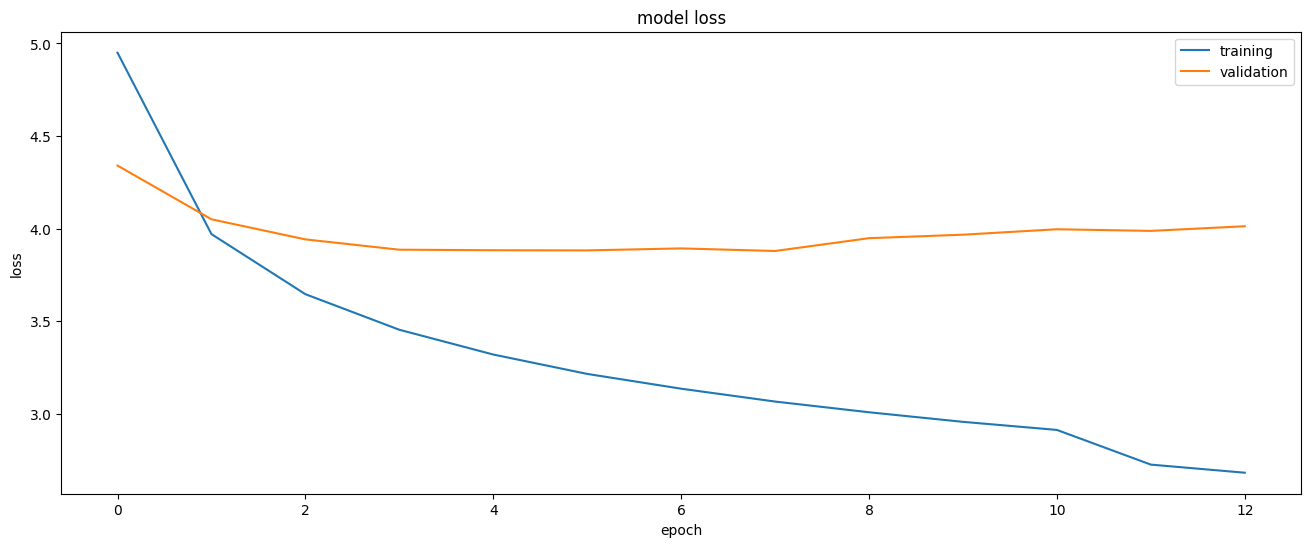

In [29]:
plt.figure(figsize=(16,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Caption Generation

In [30]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [121]:
# selected a small sample out of the validation dataset
# add a new column that will store the predicted caption

demo_samples = val_captions.sample(10)
demo_samples.reset_index(drop=True,inplace=True)
demo_samples['predicted'] = '---'

In [122]:
# generated captions and store them in the new column

counter = 0

for index,record in demo_samples.iterrows():

    counter = counter +1
    print(counter)

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    predicted = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    demo_samples.loc[index,'predicted'] = predicted

1
1/1 [==============================] - 0s 26ms/step
2
1/1 [==============================] - 0s 24ms/step
3
1/1 [==============================] - 0s 23ms/step
4
1/1 [==============================] - 0s 21ms/step
5
1/1 [==============================] - 0s 30ms/step
6
1/1 [==============================] - 0s 26ms/step
7
1/1 [==============================] - 0s 19ms/step
8
1/1 [==============================] - 0s 35ms/step
9
1/1 [==============================] - 0s 19ms/step
10
1/1 [==============================] - 0s 22ms/step


In [123]:
#remove startseq + endseq
demo_samples['predicted'] = demo_samples['predicted'].str[9:]
demo_samples['predicted'] = demo_samples['predicted'].str[:-7]

# show selected sample rows together with the predicted caption
demo_samples

,image,caption,word_count,subset,predicted
0,3501386648_e11e3f3152.jpg,startseq forest guide points something up to g...,11,val,group of people are standing in front of the f...
1,2567035103_3511020c8f.jpg,startseq brown dog runs in field with black an...,12,val,two dogs run through field
2,3052038928_9f53aa2084.jpg,startseq three men are setting up scene by mea...,18,val,two young girls are standing in front of the o...
3,2139519215_8ca16dd192.jpg,startseq young girl in blue and pink bathing s...,13,val,young girl in blue shirt is standing on the beach
4,2968885599_0672a5f016.jpg,startseq man controlling dog sled approaches a...,20,val,two dogs play tug of war in the snow
5,2856923934_6eb8832c9a.jpg,startseq two people are driving blue jet ski l...,16,val,man in blue kayak is paddling the rapids
6,3215315009_47577bf8f7.jpg,startseq someone is performing an aerial skate...,11,val,man is jumping on the side of the side of the ...
7,3117562746_62f57a02b5.jpg,startseq two dogs in the snow endseq,7,val,two dogs are running through the snow
8,639865690_d66d480879.jpg,startseq two young boys are swinging stick swo...,15,val,two people are playing in the sand
9,2635483351_bc1a8273aa.jpg,startseq black dog sits on the floor endseq,8,val,dog is jumping over the sand


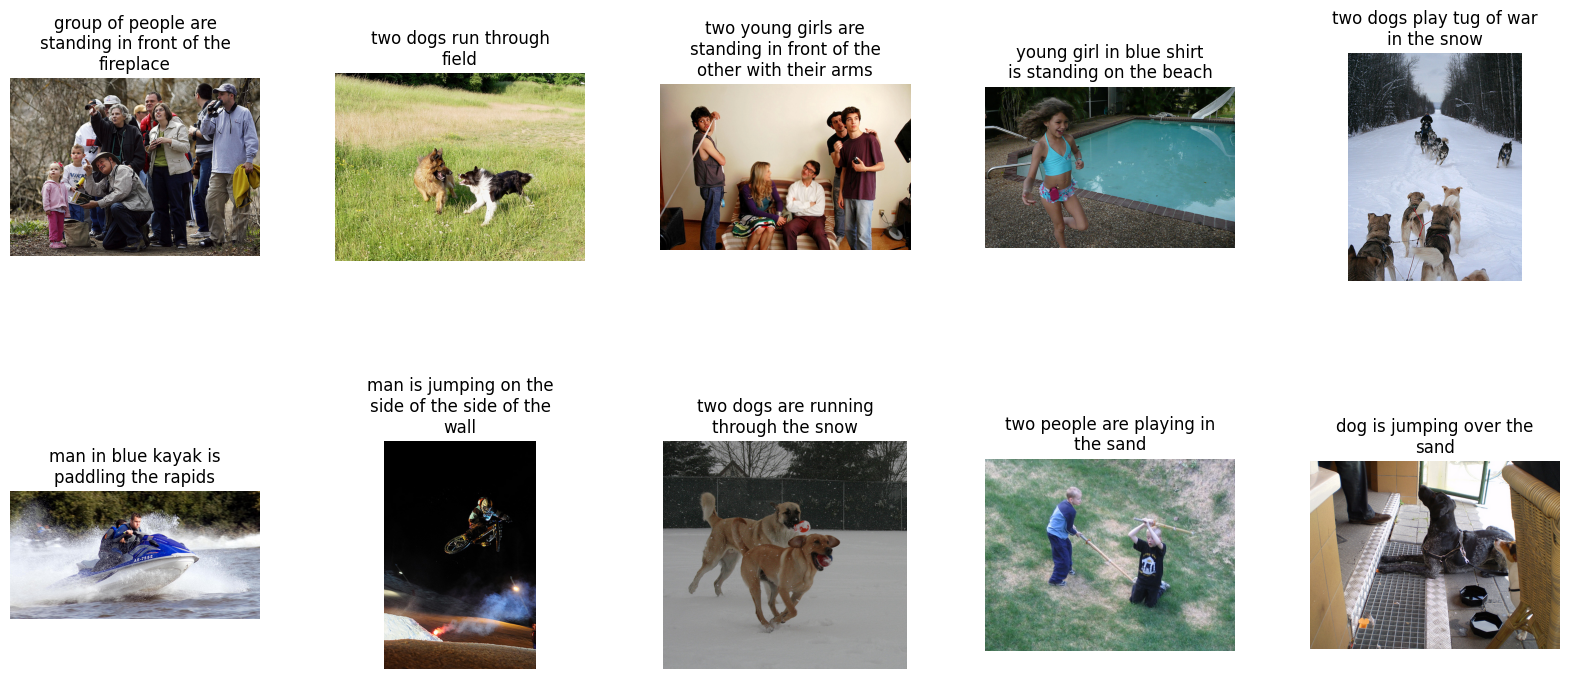

In [124]:
# visualize sample images with the predicted captions

showImages(image_path, demo_samples, [2,5], showrandom=False, captionCol='predicted')

# Load Pickles

In [114]:
# pickle_name = 'features2.pkl'
# with open(pickle_name, 'rb') as f:
#     features = pickle.load(f)

# len(features)

In [120]:
# pickle_name = 'training4.pkl'
# with open(pickle_name, 'rb') as f:
#     caption_model, history = pickle.load(f)